# Plots for Graham *et al.* - *Seabirds fuel coral reef productivity and functioning in the absence of invasive rats*

In [1]:
# Import packages
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.basemap import Basemap as bm
from scipy.stats import gaussian_kde
import scipy as sp
import pymc3 as pm
import matplotlib.image as mpimg
import matplotlib as mp
import matplotlib.image as image

import sqlite3
import os


# Return list of unique items and an index of their position in L
def indexall(L):
    poo = []
    for p in L:
        if not p in poo:
            poo.append(p)
    Ix = np.array([poo.index(p) for p in L])
    return poo,Ix

# Return list of unique items and an index of their position in long, relative to short
def subindexall(short,long):
    poo = []
    out = []
    for s,l in zip(short,long):
        if not l in poo:
            poo.append(l)
            out.append(s)
    return indexall(out)

# Function to standardize covariates
def stdize(x):
    return (x-np.mean(x))/(2*np.std(x))

# Path to plot storage
plotdir = os.getcwd()+'/plots'

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


# Rat effect on lacrymatus

In [2]:
# Import age and growth data
xdata = pd.read_csv('chagos_otolith.csv')

In [3]:
# Site
site = xdata.Site.values

# Fish ID
ID = xdata.OtolithID.values

# Length
TL = xdata.TL.values
lTL = np.log(TL)

# Bird or rat island
Treatment,It = indexall(xdata.Treatment.values)

# Age
age = xdata.Age.values

# Plotting age
agex = np.linspace(min(age),max(age),num=100)

In [4]:
# Import vonB results
vdata = pd.read_csv('vonB_results.csv')

In [5]:
# Grab posterior traces
k0 = vdata.k0.values
k_rats = vdata.k1.values
Linf = vdata.Linf.values
L0 = vdata.L0.values

In [6]:
mu_x = np.log(np.median(Linf)-(np.median(Linf)-np.median(L0))*np.exp(-(np.median(k0))*agex))
mu_y = np.log(np.median(Linf)-(np.median(Linf)-np.median(L0))*np.exp(-(np.median(k0)+np.median(k_rats))*agex))

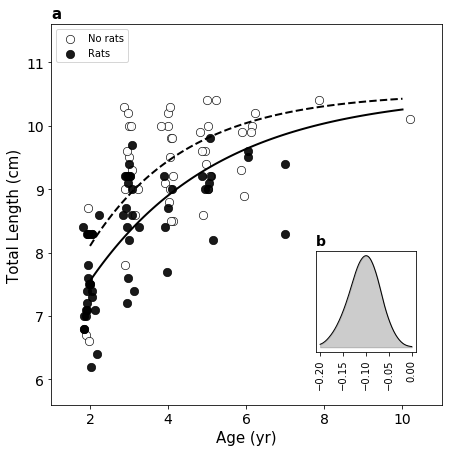

In [7]:
promarker = np.array(["o","o","^","s","s","^"])
procolour = np.array(["white","black","black","w","black","white"])
proedcol = np.array(["black","black","w","black","black","black"])
prolab = np.array(['No rats','Rats'])

# Plot model fit with data
plt.figure(figsize=(7,7))
[plt.scatter(age[It==i]+np.random.normal(0,.1,size=sum(It==i)),TL[It==i],c=procolour[i],
             linewidths=0.7,s=70,marker=promarker[i],edgecolor=proedcol[i],alpha=0.9, 
             label=prolab[i]) for i in range(2)]

# Model fit - no rats
plt.plot(agex,np.exp(mu_x),c=proedcol[0],linewidth=2,linestyle="--")

# Model fit - rats
plt.plot(agex,np.exp(mu_y),c=proedcol[0],linewidth=2)
#plt.title('Effect of rats on $P.$ $lacrymatus$ growth', fontsize=15)
plt.title('a', fontsize=15, loc='left',fontweight='bold')

plt.xlim(1,11)
plt.ylim(5.6,11.6)
plt.yticks(fontsize=14)
plt.xticks(fontsize=14)

# Axis labels
plt.xlabel('Age (yr)', fontsize=15)
plt.ylabel('Total Length (cm)', fontsize=15)

# Legend
plt.legend(scatterpoints = 1, loc='upper left')

# Rat effect size
a = plt.axes([.65, .23, .2, .2], facecolor='w')
density = gaussian_kde(k_rats)
xs = np.linspace(-0.2,0.0,200)
density.covariance_factor = lambda : .25
density._compute_covariance()
plt.plot(xs,density(xs),c='black',linewidth=1)
plt.fill_between(xs,density(xs), alpha=.2, zorder=5, antialiased=True, color="black")

#plt.title('Rat effect on $k$', fontsize=14)
plt.title('b', fontsize=14, loc='left',fontweight='bold')
plt.yticks([])
plt.xticks((0.0,-0.05,-0.1,-0.15,-0.2), rotation=90, fontsize=10)
plt.savefig('Figure_3.pdf');

# d15N model

In [8]:
# Import age and growth data
xdata = pd.read_csv('Chagos_isotope_data.csv')
xdata.head()

,Tissue,Atoll,Island,TNI_reef_area,Reef_area,To_shore_m,Treatment,cal_d13C,cal_perc_C,cal_d15N,cal_perc_N,CN_ratio
0,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-15.65,44.68,10.55,13.78,3.24
1,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-16.45,41.73,10.40,12.92,3.23
2,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-15.39,44.64,10.76,14.04,3.18
3,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-15.73,45.28,10.94,14.15,3.20
4,Fish,Great_Chagos_Bank,Eagle,0.22,25.8,280.0,Rats,-16.72,45.12,10.90,14.01,3.22


In [9]:
# Make arrays locally available
organism = xdata.Tissue.values
Organism,Io = indexall(organism)
norg = len(Organism)

It = xdata.Treatment.values=='Rats'

atoll = xdata.Atoll.values
island = xdata.Island.values

Atoll,Ia = subindexall(atoll,island)
natoll = len(Atoll)
Island,Is = indexall(island)
nisland = len(Island)
TNI = np.log(np.array([xdata.TNI_reef_area[list(island).index(i)] for i in Island]))
ReefArea = np.log(np.array([xdata.Reef_area[list(island).index(i)] for i in Island]))
Id15N = np.array([np.mean(xdata.cal_d15N.values[xdata.Island.values==i]) for i in Island])

# Distance to shore in metres 
Dshore_ = xdata.To_shore_m.values
Dshore_[np.isnan(Dshore_)] = 0
Dshore = stdize(Dshore_)
Dshore[Dshore<0] = 0

# d15N Response
d15N = xdata.cal_d15N.values
Organism

['Fish', 'Halimeda', 'Leaves', 'Soil', 'Sponge', 'Turf']

In [10]:
np.corrcoef(TNI,Id15N)

array([[1.        , 0.95880878],
       [0.95880878, 1.        ]])

In [11]:
# Open results from stored directory
results = pd.read_csv('d15N_results.csv')
results.columns.values

array(['Unnamed: 0', 'Mean_d15N', 'Island_d15N__0', 'Island_d15N__1',
       'Island_d15N__2', 'Island_d15N__3', 'Island_d15N__4',
       'Island_d15N__5', 'Island_d15N__6', 'Island_d15N__7',
       'Island_d15N__8', 'Island_d15N__9', 'Island_d15N__10',
       'Island_d15N__11', 'Organism___0', 'Organism___1', 'Organism___2',
       'Organism___3', 'Organism___4', 'Rat_effect___0', 'Rat_effect___1',
       'Rat_effect___2', 'Rat_effect___3', 'Rat_effect___4',
       'Rat_effect___5', 'Dist_to_shore', 'SD_reef', 'SD'], dtype=object)

In [12]:
# Fish no-rat intercept
g0 = results.Mean_d15N.values

# No rat intercepts
noRats = results.loc[:, results.columns.to_series().str.contains('Organism_').tolist()]+np.median(g0)
noRats.insert(0, Organism[0], g0)
noRats.columns = Organism

# Rat effects
RatEffect = results.loc[:, results.columns.to_series().str.contains('Rat_effect_').tolist()]
RatEffect.columns = Organism

# Distance to shore effect
d0 = np.median(results.Dist_to_shore.values)

In [13]:
# Revise column order
xord = ['Soil','Leaves','Halimeda','Sponge','Turf','Fish']
norg = len(xord)

# Re-order columns
noRats = noRats[xord]
RatEffect = RatEffect[xord]

In [14]:
noRats.head()

,Soil,Leaves,Halimeda,Sponge,Turf,Fish
0,13.123017,8.947475,7.234299,7.263821,3.325851,9.622935
1,13.252575,9.612545,7.342633,7.662874,3.212676,9.516126
2,13.091452,9.619642,7.486860,7.742671,3.268693,10.138789
3,13.534887,9.157538,7.228473,7.324381,3.152932,9.032702
4,13.940682,9.579291,7.566108,7.657043,3.297917,9.297548


In [15]:
RatEffect.head()

,Soil,Leaves,Halimeda,Sponge,Turf,Fish
0,-10.995083,-12.353724,-3.410683,-1.619739,-1.385085,-1.692079
1,-10.816554,-12.666305,-3.565557,-2.206577,-2.001574,-2.097418
2,-10.330054,-12.844662,-3.632942,-2.228984,-1.836321,-2.080716
3,-11.204492,-12.166785,-3.722925,-1.792361,-1.883346,-2.095689
4,-11.310741,-12.107601,-3.238417,-1.362023,-1.771429,-1.703546


# Figure 2

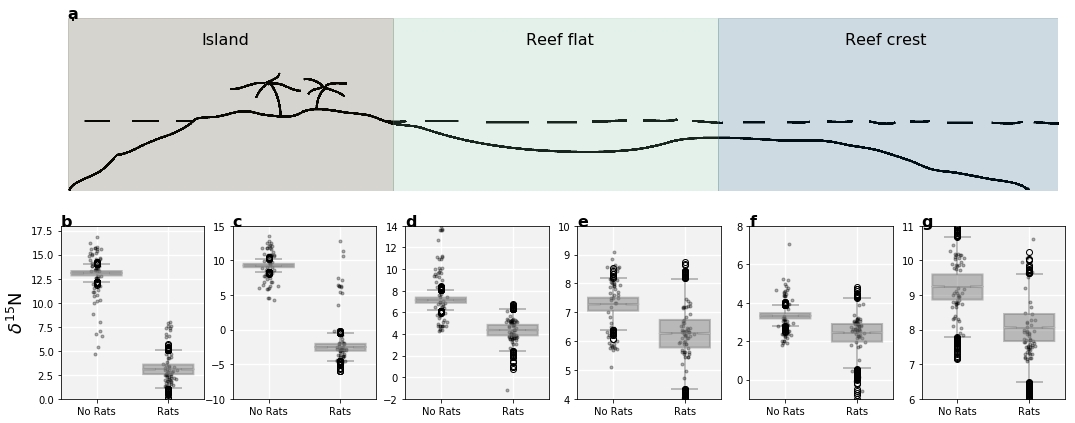

In [16]:
fig = plt.figure(figsize=(18, 7),facecolor='white')

gs = mp.gridspec.GridSpec(2, 6)
# Top reef panel
ax1 = fig.add_subplot(gs[0,:])
# Organism-specific boxplots
ax2 = fig.add_subplot(gs[1,0:1])
ax3 = fig.add_subplot(gs[1,1:2])
ax4 = fig.add_subplot(gs[1,2:3])
ax5 = fig.add_subplot(gs[1,3:4])
ax6 = fig.add_subplot(gs[1,4:5])
ax7 = fig.add_subplot(gs[1,5:6])
axout = [ax2,ax3,ax4,ax5,ax6,ax7]

labx = 'abcdefg'

# Panel colours
#rcol = np.array(['brown','brown','turquoise','turquoise','blue','blue'])
#rcol = np.array(['burlywood','burlywood','lightseagreen','lightseagreen','lightskyblue','lightskyblue'])
#rcol = np.array(['#EFD1AB','#EFD1AB','#D1D1B5','#D1D1B5','#99BCB6','#99BCB6'])
rcol = np.array(['#352913','#352913','#79BD9A','#79BD9A','#0B486B','#0B486B'])

# Reef figure
img = mpimg.imread('AC792E06.png')
ax1.imshow(img)
ax1.axis('off')
ialpha = 0.5
iff = 0.3
ifsize = 16


ax1.add_patch(mp.patches.Rectangle((0, 0), 1550, 900, alpha=ialpha-iff, color=rcol[0]))
ax1.annotate('Island', (750, 100), color='black', weight='regular', fontsize=ifsize, ha='center', va='center')

ax1.add_patch(mp.patches.Rectangle((1550, 0), 1550, 900, alpha=ialpha-iff, color=rcol[2]))
ax1.annotate('Reef flat', (750+1600, 100), color='black', weight='regular', fontsize=ifsize, ha='center', va='center')

ax1.add_patch(mp.patches.Rectangle((3100, 0), 1650, 900, alpha=ialpha-iff, color=rcol[4]))
ax1.annotate('Reef crest', (750+3150, 100), color='black', weight='regular', fontsize=ifsize, ha='center', va='center')
ax1.annotate(labx[0], (0,0), fontweight='bold', fontsize=16)

ax1.patch.set_facecolor('1.')
ax1.grid(False)


# Paired boxplots
xwid = .7

# Add y-axis name
ax2.set_ylabel(r"$\delta^{15}$N",fontsize=18)

# Line widths
lwds = 2

ymin = [0,-10,-2,4,-1,6]
ymax = [18,15,14,10,8,11]

for i in range(norg):
    xnr = noRats[xord[i]].values
    xr = noRats[xord[i]].values+RatEffect[xord[i]].values
    # Boxplot
    bp = axout[i].boxplot([xnr,xr],labels=('No Rats','Rats'), patch_artist=True, notch=True, widths=(xwid, xwid))
    axout[i].grid(True, 'major', color='w', linestyle='-', linewidth=1.4)
    axout[i].grid(True, 'minor', color='b', linestyle='-', linewidth=0.7)
    axout[i].patch.set_facecolor('.95')
    #axout[i].patch.set_edgecolor('black')
    wcol = 'grey'
    plt.setp(bp['whiskers'], color=wcol, linestyle = 'solid', linewidth=lwds, alpha=ialpha)
    plt.setp(bp['medians'], color=wcol, linewidth=lwds, alpha=ialpha)
    plt.setp(bp['caps'], color=wcol, linewidth=lwds, alpha=ialpha)
    for box in bp['boxes']:
        #box.set( color=wcol, linewidth=lwds, alpha=ialpha)
        box.set( facecolor=rcol[i], color=wcol, linewidth=lwds, alpha=ialpha)

    #plt.setp(bp['caps'], color='black', linewidth=2)
    
    # Data
    indx = xdata.Tissue.values==xord[i]
    tmp = xdata[indx]
    ex = 0
    if xord[i]=='Turf' or xord[i]=='Fish':
        ex = d0*Dshore[indx]
    x = (tmp.Treatment.values=='Rats')*1
    xs = np.random.normal(x, 0.04, size=len(x))+1
    axout[i].plot(xs, tmp.cal_d15N.values-ex, 'k.', alpha=0.3)
    axout[i].annotate(labx[i+1], (0.5,ymax[i]), fontweight='bold', fontsize=16)
    #if xord[i]=='Fish':
    axout[i].set_ylim(ymin[i],ymax[i])
    #axout[i].annotate(Organism[i], (1.5, axout[i].get_ylim()[0]), color='black', weight='regular', fontsize=12, ha='center', va='center')

plt.savefig('Figure_2.pdf')

## Figure 1

In [17]:
# Import age and growth data
ydata = pd.read_csv('Chagos_bird_heatmaps.csv')
ydata

,Atoll,Island,Treatment,Seabirds_ha,Booby,Frigatebird,Noddy,Shearwater,Tern,Tropicbird,kg_N_ha_yr
0,Great_Chagos_Bank,Eagle_Island,Rats,0.55,0.00,0.00,0.04,0.00,0.03,0.00,0.22
1,Great_Chagos_Bank,Middle_Brother,No_rats,3701.81,4.18,0.71,2.60,0.00,596.21,0.00,424.83
2,Great_Chagos_Bank,Nelson_Island,No_rats,182.57,0.94,2.97,14.61,0.11,0.10,0.00,119.33
3,Great_Chagos_Bank,South_Brother,No_rats,972.89,0.56,0.00,95.26,7.76,39.87,0.00,172.44
4,Peron_Banhos,Grande_Ile_Coquillage,No_rats,1160.90,3.24,5.39,14.96,0.00,160.40,0.00,213.46
5,Peron_Banhos,Grande_Ile_Mapou,Rats,1.92,0.04,0.00,0.13,0.00,0.05,0.00,1.16
6,Peron_Banhos,Ile_Longue,No_rats,1426.88,1.87,0.00,6.42,0.00,218.04,0.00,206.42
7,Peron_Banhos,Ile_Poule,Rats,0.22,0.00,0.00,0.02,0.00,0.01,0.00,0.04
8,Peron_Banhos,PB_Ile_Anglaise,Rats,2.50,0.00,0.00,0.21,0.00,0.16,0.00,0.53
9,Salomon,Ile_de_la_Passe,No_rats,15.29,0.13,0.00,1.61,0.00,0.13,0.03,6.06


In [18]:
ydata['logSeabirds_ha'] = np.log(ydata.Seabirds_ha.values)

In [19]:
Birds = ['Booby','Frigatebird','Noddy','Shearwater','Tern','Tropicbird']
nbirds = len(Birds)

Inames = list(np.sort(ydata.Island.values[ydata.Treatment.values=='No_rats']))+['']+list(np.sort(ydata.Island.values[ydata.Treatment.values=='Rats']))
Inamez = [x.replace('_',' ') for x in Inames]
ninames = len(Inames)

Ilands = ydata.Island.values


In [20]:
# Get indexing and densities for plot
row = []
col = []
value = []

for i in range(nisland):
    for b in Birds:
        row += [Birds.index(b)]
        col += [Inames.index(Ilands[i])]
        value += [np.log(ydata[b].values[i]+1)]

In [21]:
A = sp.sparse.csc_matrix((value, (row, col)), shape=(nbirds,ninames)).toarray()

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


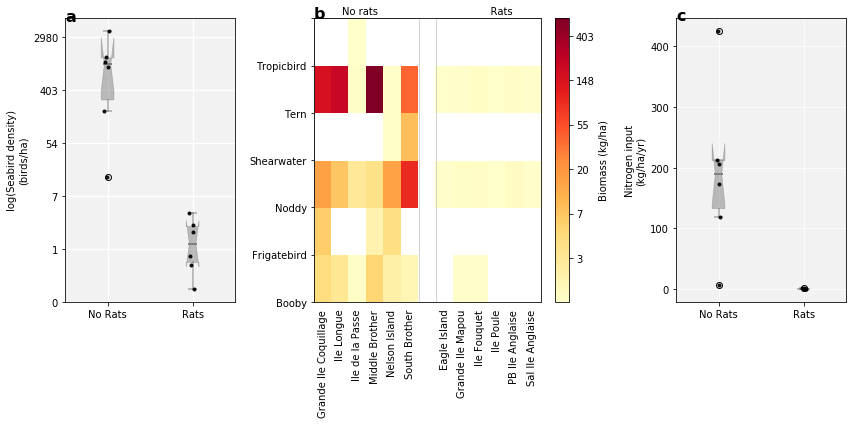

In [22]:
# Set up multipanel grid
fig = plt.figure(figsize=(12, 6),facecolor='white')
gs = mp.gridspec.GridSpec(1, 3, width_ratios=[3, 5, 3])
ax_ = np.array([[fig.add_subplot(gs[i,j]) for i in range(1)] for j in range(3)]).reshape(3,)

# = = = = = = = box plot of seabird density (number/ha) rats vs no rats (column D)
ax = ax_[0]
x1 = ydata.logSeabirds_ha[ydata.Treatment=='No_rats']
x2 = ydata.logSeabirds_ha[ydata.Treatment=='Rats']
bp = ax.boxplot([x1,x2], labels=('No Rats','Rats'), patch_artist=True,notch=True)

# Make look pretty
ax.grid(True, 'major', color='w', linestyle='-', linewidth=1.4)
ax.grid(True, 'minor', color='b', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('.95')
wcol = 'grey'
plt.setp(bp['whiskers'], color=wcol, linestyle = 'solid', linewidth=lwds, alpha=ialpha)
plt.setp(bp['medians'], color=wcol, linewidth=lwds, alpha=1)
plt.setp(bp['caps'], color=wcol, linewidth=lwds, alpha=ialpha)
for box in bp['boxes']:
    box.set( facecolor=rcol[0], color=wcol, linewidth=.7, alpha=ialpha)

# Add data
x = (ydata.Treatment.values=='Rats')*1
xs = np.random.normal(x, 0.02, size=len(x))+1
ax.plot(xs, ydata.logSeabirds_ha.values, 'k.', alpha=.9, zorder=3)
ax.set_ylabel('log(Seabird density)\n(birds/ha)')
ax.set_yticklabels(np.exp([-4,-2,0,2,4,6,8]).astype(int).astype(str))
ax.annotate('a', (0.5,8.6), fontweight='bold', fontsize=16)

# = = = = = = = heat map of seabird family biomass (kg/ha) in rats versus no rats (columns E-J)
ax = ax_[1]

lwdx = 0.9
# Set colours
a = np.ma.masked_where(A<=0, A)
cmap = plt.cm.YlOrRd
cmap.set_bad(color='white')
X = ax.pcolormesh(a, cmap=cmap)
CX = plt.colorbar(X, ax=ax_[1])
CX.set_ticks(np.arange(1,7))
CX.set_ticklabels(np.round(np.exp(np.arange(1,7))).astype(int).astype(str), update_ticks=True)
CX.set_label('Biomass (kg/ha)')

ax.set_xlabel('No rats                                    Rats')    
ax.xaxis.set_label_position('top') 
ax.set_yticklabels(Birds)
ax.set_xticklabels(Inamez,rotation='vertical')
ax.set_xticks(np.arange(ninames)+0.5)
ax.tick_params(axis='y', which='both', bottom='off', top='off')
ax.tick_params(axis='x', which='both', bottom='off', top='off')
ax.vlines((0,13),ymin=0,ymax=6,color='darkgrey',linewidth=lwdx)
ax.vlines((6,7),ymin=0,ymax=6,color='darkgrey',linewidth=lwdx-0.4)
ax.hlines((0,6),xmin=0,xmax=6,color='darkgrey',linewidth=lwdx)
ax.hlines((0,6),xmin=7,xmax=13,color='darkgrey',linewidth=lwdx)
ax.annotate('b', (0.,6), fontweight='bold', fontsize=16)
ax.grid(False)


# = = = = = = = box plot of nitrogen input – kg of N ha-1 yr-1 (column K)
ax = ax_[2]
x1 = ydata.kg_N_ha_yr[ydata.Treatment=='No_rats']
x2 = ydata.kg_N_ha_yr[ydata.Treatment=='Rats']
bp = ax.boxplot([x1,x2], labels=('No Rats','Rats'), patch_artist=True,notch=True)

# Make look pretty
ax.grid(True, 'major', color='w', linestyle='-', linewidth=0.7)
ax.grid(True, 'minor', color='b', linestyle='-', linewidth=0.7)
ax.patch.set_facecolor('.95')
wcol = 'grey'
plt.setp(bp['whiskers'], color=wcol, linestyle = 'solid', linewidth=lwds, alpha=ialpha)
plt.setp(bp['medians'], color=wcol, linewidth=lwds, alpha=1)
plt.setp(bp['caps'], color=wcol, linewidth=lwds, alpha=ialpha)
for box in bp['boxes']:
    box.set( facecolor=rcol[0], color=wcol, linewidth=.7, alpha=ialpha)

# Add data
x = (ydata.Treatment.values=='Rats')*1
xs = np.random.normal(x, 0.02, size=len(x))+1
ax.plot(xs, ydata.kg_N_ha_yr.values, 'k.', alpha=.9, zorder=3)
ax.set_ylabel('Nitrogen input\n(kg/ha/yr)')
ax.annotate('c', (0.5,443), fontweight='bold', fontsize=16)
plt.tight_layout()

plt.savefig('Figure_1.pdf');

# Figure 4

In [23]:
zdata = pd.read_csv('Chagos_rats_birds_UVC_data.csv')
zdata['lBiomass'] = np.log(zdata.Biomass)
zdata.head()

,Atoll,Island,Treatment,Transect,Area,Family,Species,Function,Structure,Coral_cover,Length,Biomass,Abundance,lBiomass
0,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Ctenochaetus_striatus,Herbivore,2.0,12.67,13,4.0,66.7,1.386294
1,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Naso_brachycentron,Herbivore,2.0,12.67,33,49.6,66.7,3.903991
2,Great_Chagos_Bank,Eagle,Rats,1,150,Scaridae,Chlorurus_sordidus,Herbivore,2.0,12.67,13,3.3,66.7,1.193922
3,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Acanthurus_nigrofuscus,Herbivore,2.0,12.67,13,4.1,66.7,1.410987
4,Great_Chagos_Bank,Eagle,Rats,1,150,Acanthuridae,Acanthurus_nigrofuscus,Herbivore,2.0,12.67,12,3.2,66.7,1.163151


In [24]:
# Generate new index
kdata = zdata.set_index(['Atoll', 'Island', 'Transect'])
kdata.head()

Treatment  Area        Family  \
Atoll             Island Transect                                 
Great_Chagos_Bank Eagle  1             Rats   150  Acanthuridae   
                         1             Rats   150  Acanthuridae   
                         1             Rats   150      Scaridae   
                         1             Rats   150  Acanthuridae   
                         1             Rats   150  Acanthuridae   

                                                  Species   Function  \
Atoll             Island Transect                                      
Great_Chagos_Bank Eagle  1          Ctenochaetus_striatus  Herbivore   
                         1             Naso_brachycentron  Herbivore   
                         1             Chlorurus_sordidus  Herbivore   
                         1         Acanthurus_nigrofuscus  Herbivore   
                         1         Acanthurus_nigrofuscus  Herbivore   

                                   Structure  Coral_cover  Length  Biomass  \
Atoll             Island Transect                                            
Great_Chagos_Bank Eagle  1               2.0        12.67      13      4.0   
                         1               2.0        12.67      33     49.6   
                         1               2.0        12.67      13      3.3   
                         1               2.0        12.67      13      4.1   
                         1               2.0        12.67      12      3.2   

                                   Abundance  lBiomass  
Atoll             Island Transect                       
Great_Chagos_Bank Eagle  1              66.7  1.386294  
                         1              66.7  3.903991  
                         1              66.7  1.193922  
                         1              66.7  1.410987  
                         1              66.7  1.163151

In [25]:
# Split data frames into functional groups
Herbs = zdata[zdata.Function=='Herbivore']
Plank = zdata[zdata.Function=='Planktivore']
Pisci = zdata[zdata.Function=='Piscivore']
Mixed = zdata[zdata.Function=='Mixed-diet']
Corali = zdata[zdata.Function=='Corallivore']
Inverti = zdata[zdata.Function=='Invertivore']
Total = zdata
Obx = [Herbs,Plank,Pisci,Mixed,Corali,Inverti]

In [26]:
# Grab summarized data for modelling
# Responses
h_lbiomass = np.log(Herbs.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel())
pl_lbiomass = np.log(Plank.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
pi_lbiomass = np.log(Pisci.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
mi_lbiomass = np.log(Mixed.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
c_lbiomass = np.log(Corali.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
i_lbiomass = np.log(Inverti.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()+1)
lbiomass = np.log(Total.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel())
rdata = [h_lbiomass,pl_lbiomass,pi_lbiomass,mi_lbiomass,c_lbiomass,i_lbiomass]
Res_names = ['Herbivores','Planktivores','Piscivores','Mixed-diet','Corallivores','Invertivores']

# Covariates
structure = np.array([x[0] for x in Total.groupby(['Atoll','Island','Transect'])['Structure'].unique().ravel()])
struct = structure-np.mean(structure)
hc = np.array([x[0] for x in Total.groupby(['Atoll','Island','Transect'])['Coral_cover'].unique().ravel()])
treatment = np.array([x[0] for x in Total.groupby(['Atoll','Island','Transect'])['Treatment'].unique().ravel()])
It = (treatment=='Rats')*1

# Hierarchy
Atoll_, Island_, Transect_ = np.array([np.array(x) for x in kdata.index.unique()]).T
Atoll,Ia = subindexall(Atoll_,Island_)
natoll = len(Atoll)
Island,Is = indexall(Island_)
nisland = len(Island)

In [27]:
# Import age and growth data
gdata = pd.read_excel('Rats_birds_func.xlsx')
gdata['zSC'] = gdata['Structural_complexity']-np.mean(gdata['Structural_complexity'])
gdata.head()

,Treatment,Atoll,Island,Transect,grazing_prop_reef,Erosion_t_ha,Structural_complexity,Coral_cover,zSC
0,No_rats,Great_Chagos_Bank,Middle_Brother,1,11.800741,155.013787,3.000000,6.330,0.666934
1,No_rats,Great_Chagos_Bank,Middle_Brother,2,11.303339,121.614844,2.987179,40.330,0.654113
2,No_rats,Great_Chagos_Bank,Middle_Brother,3,3.511624,62.013236,2.000000,23.692,-0.333066
3,No_rats,Great_Chagos_Bank,Middle_Brother,4,2.211482,34.852228,2.000000,32.000,-0.333066
4,No_rats,Great_Chagos_Bank,Nelson_Island,1,18.567027,154.658501,1.500000,12.670,-0.833066


In [28]:
gresults = pd.read_csv('grazing_results.csv')
eresults = pd.read_csv('erosion_results.csv')

In [29]:
FG = ['Herbivore', 'Mixed_diet','Piscivore','Planktivore','Invertivore', 'Corallivore']
RatEffects = {}
# Grab rat effect sizes for biomass
RatEffects['Herbivore'] = pd.read_csv('Herbivores_results.csv')['Rat_effect']
RatEffects['Mixed_diet'] = pd.read_csv('Mixed-diet_results.csv')['Rat_effect']
RatEffects['Piscivore'] = pd.read_csv('Piscivores_results.csv')['Rat_effect']
RatEffects['Planktivore'] = pd.read_csv('Planktivores_results.csv')['Rat_effect']
RatEffects['Invertivore'] = pd.read_csv('Invertivores_results.csv')['Rat_effect']
RatEffects['Corallivore'] = pd.read_csv('Corallivores_results.csv')['Rat_effect']

In [30]:
# Grab global intercepts
g0 = {}
g0['Herbivore'] = pd.read_csv('Herbivores_results.csv')['Mean_biomass']
g0['Mixed_diet'] = pd.read_csv('Mixed-diet_results.csv')['Mean_biomass']
g0['Piscivore'] = pd.read_csv('Piscivores_results.csv')['Mean_biomass']
g0['Planktivore'] = pd.read_csv('Planktivores_results.csv')['Mean_biomass']
g0['Invertivore'] = pd.read_csv('Invertivores_results.csv')['Mean_biomass']
g0['Corallivore'] = pd.read_csv('Corallivores_results.csv')['Mean_biomass']

# Grab hard coral effect intercepts
g1 = {}
g1['Herbivore'] = pd.read_csv('Herbivores_results.csv')['Hard_coral']
g1['Mixed_diet'] = pd.read_csv('Mixed-diet_results.csv')['Hard_coral']
g1['Piscivore'] = pd.read_csv('Piscivores_results.csv')['Hard_coral']
g1['Planktivore'] = pd.read_csv('Planktivores_results.csv')['Hard_coral']
g1['Invertivore'] = pd.read_csv('Invertivores_results.csv')['Hard_coral']
g1['Corallivore'] = pd.read_csv('Corallivores_results.csv')['Hard_coral']

# Grab structure effect intercepts
g2 = {}
g2['Herbivore'] = pd.read_csv('Herbivores_results.csv')['Structure']
g2['Mixed_diet'] = pd.read_csv('Mixed-diet_results.csv')['Structure']
g2['Piscivore'] = pd.read_csv('Piscivores_results.csv')['Structure']
g2['Planktivore'] = pd.read_csv('Planktivores_results.csv')['Structure']
g2['Invertivore'] = pd.read_csv('Invertivores_results.csv')['Structure']
g2['Corallivore'] = pd.read_csv('Corallivores_results.csv')['Structure']

In [31]:
min(g0['Corallivore'].values)

-1.411005669734788

In [32]:
# Average structure effect size per FG
G2 = np.array([np.median(g2[x]) for x in FG])
# Average structural complexity
SC = gdata['zSC'].mean()

In [33]:
# Grab marginal intercept
G0 = np.array([np.median(g0[x]) for x in FG])+np.array([np.median(g1[x]) for x in FG])*np.mean(hc)+G2*SC

In [34]:
# Grab UIs for log-differences in fish biomass
mu_ = np.array([np.median(np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC)-np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC+RatEffects[x])) for x in FG])

xl95_ = np.array([np.percentile(np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC)-np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC+RatEffects[x]),2.5) for x in FG])

xl50_ = np.array([np.percentile(np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC)-np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC+RatEffects[x]),25) for x in FG])

xu50_ = np.array([np.percentile(np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC)-np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC+RatEffects[x]),75) for x in FG])

xu95_ = np.array([np.percentile(np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC)-np.exp(g0[x]+g1[x]*np.mean(hc)+g2[x]*SC+RatEffects[x]),97.5) for x in FG])

In [35]:
mu = np.log(mu_+1)
xl95 = -np.log(abs(xl95_)+1)
xl50 = np.log(xl50_+1)
xu50 = np.log(xu50_+1)
xu95 = np.log(xu95_+1)

/Users/aaronmacneil/anaconda/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


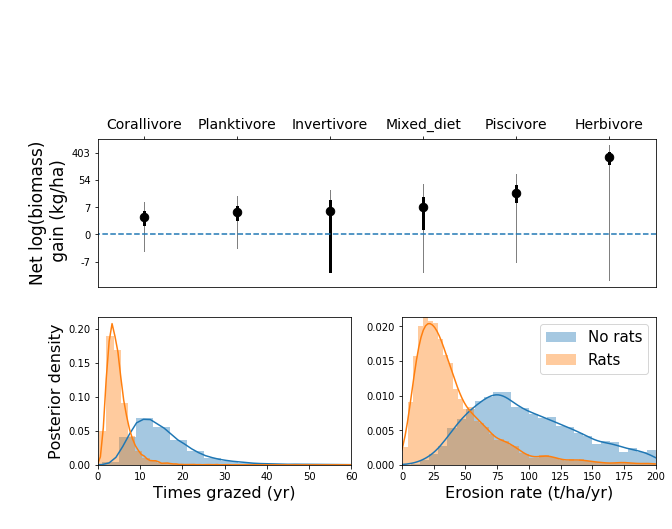

In [36]:
# Effect size plot
# Set up multipanel grid
fig = plt.figure(figsize=(10, 6),facecolor='white')
gs = mp.gridspec.GridSpec(2, 2)

def il(x):
    return np.exp(x)/(1+np.exp(x))

ax1 = plt.subplot2grid((2, 2), (0, 0), colspan=3)
ax2 = plt.subplot2grid((2, 2), (1, 0))
ax3 = plt.subplot2grid((2, 2), (1, 1))


##############################
aticks = np.array([-np.exp(2),0,np.exp(2),np.exp(4),np.exp(6)]).astype(int).astype(str)
ypos = sorted(range(len(FG)), key=lambda k: mu[k])

ax1.scatter(np.arange(len(FG)), mu[ypos], s=72, c='black')
for xl,xL,xU,xu,y in zip(xl95[ypos],xl50[ypos],xu50[ypos],xu95[ypos],np.arange(len(FG))):
    ax1.plot((y,y),(xl,xu),'k-',linewidth=1,c='grey')
    ax1.plot((y,y),(xL,xU),'k-',linewidth=3)

# Axis labels
ax1.set_xlabel('')
ax1.set_xticks(np.arange(6))
ax1.set_xticklabels(np.array(FG)[ypos],fontsize=14)
ax1.set_ylabel('Net log(biomass)\n gain (kg/ha)',fontsize=17)
ax1.set_yticks((-2,0,2,4,6))
ax1.set_yticklabels(aticks)
ax1.xaxis.tick_top()
    
# Tidy plotting    
ax1.plot((-10,10),(0,0),'--')
#ax1.set_ylim(-10,200)
ax1.set_xlim(-.5,5.5)
ax1.annotate('a', (-.5,500), fontweight='bold', fontsize=16)


##############################

tmp = gresults.Average_grazing.values
oset = np.median(gresults.complexity.values)*np.mean(gdata.Structural_complexity.values)+np.median(gresults.hc.values)*np.mean(gdata.Coral_cover.values)

sns.distplot(np.exp(tmp+oset),ax=ax2,label='No rats')
sns.distplot(np.exp(np.median(tmp+oset)+gresults.Rat_effect.values),ax=ax2,label='Rats')
ax2.set_xlabel('Times grazed (yr)',fontsize=16)
ax2.set_ylabel('Posterior density',fontsize=16)
ax2.set_xlim(0,60)
ax2.annotate('b', (0.01,.219), fontweight='bold', fontsize=16)


##############################

tmp = eresults.Average_grazing.values
oset = np.median(eresults.complexity.values)*np.mean(gdata.Structural_complexity.values)+np.median(eresults.hc.values)*np.mean(gdata.Coral_cover.values)

maxx = 200
x1 = np.exp(tmp+oset)
x2 = np.exp(np.median(tmp+oset)+eresults.Rat_effect.values)
sns.distplot(x1[x1<maxx],ax=ax3,label='No rats')
sns.distplot(x2[x2<maxx],ax=ax3,label='Rats')
ax3.set_xlabel('Erosion rate (t/ha/yr)',fontsize=16)
ax3.annotate('c', (0.01,.0219), fontweight='bold', fontsize=16)
ax3.set_xlim(0,maxx)
ax3.legend(fontsize=15)

#plt.tight_layout()
plt.savefig('Figure_4.pdf');

# Quoted quantities

In [37]:
ydata.head()

,Atoll,Island,Treatment,Seabirds_ha,Booby,Frigatebird,Noddy,Shearwater,Tern,Tropicbird,kg_N_ha_yr,logSeabirds_ha
0,Great_Chagos_Bank,Eagle_Island,Rats,0.55,0.00,0.00,0.04,0.00,0.03,0.0,0.22,-0.597837
1,Great_Chagos_Bank,Middle_Brother,No_rats,3701.81,4.18,0.71,2.60,0.00,596.21,0.0,424.83,8.216577
2,Great_Chagos_Bank,Nelson_Island,No_rats,182.57,0.94,2.97,14.61,0.11,0.10,0.0,119.33,5.207134
3,Great_Chagos_Bank,South_Brother,No_rats,972.89,0.56,0.00,95.26,7.76,39.87,0.0,172.44,6.880271
4,Peron_Banhos,Grande_Ile_Coquillage,No_rats,1160.90,3.24,5.39,14.96,0.00,160.40,0.0,213.46,7.056951


In [38]:
# Seabird density ratio between treatments
tmp = ydata.groupby(['Treatment'])['Seabirds_ha'].mean()
tmp, tmp[0]/tmp[1]

(Treatment
 No_rats    1243.390000
 Rats          1.636667
 Name: Seabirds_ha, dtype: float64, 759.7087576374747)

In [39]:
# Nitrogen deposition rates between treatments
tmp = ydata.groupby(['Treatment'])['kg_N_ha_yr'].mean()
tmp, tmp[0]/tmp[1]

(Treatment
 No_rats    190.423333
 Rats         0.758333
 Name: kg_N_ha_yr, dtype: float64, 251.1076923076923)

In [40]:
# Grazing rates between treatments
tmp = gdata.groupby(['Treatment'])['grazing_prop_reef'].median()
tmp, tmp[0]/tmp[1]

(Treatment
 No_rats    9.012065
 Rats       2.848693
 Name: grazing_prop_reef, dtype: float64, 3.163579293107316)

In [41]:
# Erosion rates between treatments
tmp = gdata.groupby(['Treatment'])['Erosion_t_ha'].median()
tmp, tmp[0]/tmp[1]

(Treatment
 No_rats    93.869257
 Rats       24.501190
 Name: Erosion_t_ha, dtype: float64, 3.831212132651365)

In [42]:
# Total fish biomass difference between treatments
tmp = Total.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1])

1.4763206542173204

In [43]:
# Herbivore fish biomass difference between treatments
tmp = Herbs.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1]),np.mean(tmp[It==0])-np.mean(tmp[It==1])

(1.2638502214166931, 117.67500000000001)

In [44]:
# Mixed-diet fish biomass difference between treatments
tmp = Mixed.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1]),np.mean(tmp[It==0])-np.mean(tmp[It==1])

(3.2021237641889413, 25.05833333333333)

In [45]:
# Piscivore fish biomass difference between treatments
tmp = Pisci.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1]),np.mean(tmp[It==0])-np.mean(tmp[It==1])

(2.600132993461155, 60.15833333333333)

In [46]:
# Planktivore fish biomass difference between treatments
tmp = Plank.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1]),np.mean(tmp[It==0])-np.mean(tmp[It==1])

(6.050619834710744, 20.370833333333337)

In [47]:
# Invertivore fish biomass difference between treatments
tmp = Inverti.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1]),np.mean(tmp[It==0])-np.mean(tmp[It==1])

(1.956789219276403, 27.216666666666672)

In [48]:
# Corallivore fish biomass difference between treatments
tmp = Corali.groupby(['Atoll','Island','Transect'])['Biomass'].sum().ravel()
np.mean(tmp[It==0])/np.mean(tmp[It==1]),np.mean(tmp[It==0])-np.mean(tmp[It==1])

(1.6443825441039923, 2.8916666666666657)

In [49]:
# Grazing posteriors
gresults.quantile([.025,.25,.5,.75,.975])

,Unnamed: 0,Average_grazing,Island_d15N__0,Island_d15N__1,Island_d15N__2,Island_d15N__3,Island_d15N__4,Island_d15N__5,Island_d15N__6,Island_d15N__7,Island_d15N__8,Island_d15N__9,Island_d15N__10,Island_d15N__11,Rat_effect,complexity,hc,SD_reef
0.025,249.975,0.422113,-0.110267,1.988040,-0.001877,1.039131,0.529224,0.594557,-0.828049,0.751763,-0.556613,1.148642,-0.395286,0.255741,-2.270546,-0.168687,0.028450,0.501345
0.250,2499.750,1.039775,0.403754,2.329941,0.476055,1.453128,1.026759,1.055400,0.135802,1.594439,0.358241,1.959624,0.472107,1.101070,-1.529038,0.014577,0.034122,0.676856
0.500,4999.500,1.355863,0.669354,2.505574,0.712202,1.664421,1.266942,1.297569,0.573052,2.022379,0.807492,2.367898,0.908116,1.526977,-1.185674,0.114345,0.037056,0.809906
0.750,7499.250,1.667117,0.936840,2.692529,0.937132,1.886627,1.521960,1.531275,0.985735,2.438204,1.226840,2.751908,1.325224,1.932398,-0.852904,0.207494,0.040206,0.982367
0.975,9749.025,2.285528,1.431261,3.028929,1.400559,2.299754,1.974264,1.975959,1.800154,3.333997,2.105478,3.630023,2.194350,2.829765,-0.104516,0.392417,0.046474,1.459414


In [50]:
# Erosion posteriors
eresults.quantile([.025,.25,.5,.75,.975])

,Unnamed: 0,Average_grazing,Island_d15N__0,Island_d15N__1,Island_d15N__2,Island_d15N__3,Island_d15N__4,Island_d15N__5,Island_d15N__6,Island_d15N__7,Island_d15N__8,Island_d15N__9,Island_d15N__10,Island_d15N__11,Rat_effect,complexity,hc,SD_reef
0.025,124.975,1.958277,2.640791,3.783788,1.187355,3.264678,2.908253,2.885448,-1.052528,2.604722,1.624794,2.972339,0.857195,1.635350,-2.634017,0.005419,0.044998,0.813529
0.250,1249.750,2.677589,2.801443,3.897082,1.432887,3.401531,3.060950,3.042015,0.093513,3.674772,2.686009,4.022426,1.917366,2.687109,-1.587411,0.067088,0.047043,1.066734
0.500,2499.500,3.025874,2.894003,3.958643,1.548821,3.474365,3.146203,3.123083,0.685743,4.207307,3.227127,4.560506,2.438290,3.226571,-1.091825,0.100339,0.048112,1.249663
0.750,3749.250,3.395038,2.980011,4.023003,1.668794,3.546651,3.229344,3.210056,1.214274,4.709099,3.722323,5.060758,2.946334,3.725241,-0.569405,0.131791,0.049203,1.495789
0.975,4874.025,4.203887,3.145991,4.144711,1.885894,3.683046,3.386936,3.364810,2.256416,5.781812,4.780628,6.110910,3.998066,4.779884,0.456597,0.194397,0.051253,2.187843


In [51]:
# Rat effect on growth rate
np.percentile(k_rats,[2.5,25,50,75,97.5])

array([-0.175892  , -0.12612665, -0.1026481 , -0.08045454, -0.03978968])